# ReadIn training
In this noteboook, we train the fist component described in the report

In [1]:

%load_ext autoreload
%autoreload 2
     
import torch
import os
from matplotlib import pyplot as plt
from csng.brainreader_mouse.data import get_brainreader_mouse_dataloaders

import os
import torch

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from csng.imagenet.models import ReadIn, ResnetExtractor, UpsampleModel, count_parameters
import datetime

assert torch.cuda.is_available()

Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


## Hyperparameters

In [2]:

device = os.environ["DEVICE"]
DATA_PATH = os.environ['DATA_PATH']
CACHE_DIR = os.path.join(DATA_PATH, 'brainreader_cache')
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, 'brainreader')

BATCH_SIZE = 64
EPOCHS = 70
EPOCHS_PER_VALIDATION = 5
WEIGHT_DECAY=0e-4
LEARNING_RATE = .0002* BATCH_SIZE
READIN_DTYPE = torch.bfloat16
MODEL_PATH = os.environ['MODELS_PATH']
RESNET_DECODE_MODEL = os.path.join(MODEL_PATH, 'mlp2489100.pt')

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


## Importing the dataset

In [3]:
# Configuration for the Brainreader mouse dataloader creation
config = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "data": {
        "mixing_strategy": "sequential", # needed only with multiple base dataloaders
        "max_training_batches": None,
    },
    "save_path": os.path.join(DATA_PATH, "models", "encoder_ball_50.pt"),
    # "load_ckpt": os.path.join(DATA_PATH, "models", "encoder_ball.pt"),
    "train": True,
}
config["data"]["brainreader_mouse"] = {
    "device": config["device"],
    "mixing_strategy": config["data"]["mixing_strategy"],
    "max_batches": None,
    "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
    "batch_size": BATCH_SIZE,
    # "sessions": list(range(1, 23)),
    "sessions": [6],
    "resize_stim_to": (224, 224),
    "normalize_stim": False,
    "normalize_resp": True,
    "div_resp_by_std": True,
    "clamp_neg_resp": True,
    "additional_keys": None,
    "avg_test_resp": True,
}

dl = get_brainreader_mouse_dataloaders(config=config["data"]["brainreader_mouse"])['brainreader_mouse']
print(len(dl['train']), len(dl['val']))

71 8


1
torch.Size([64, 1, 224, 224])
torch.Size([64, 8587])
6


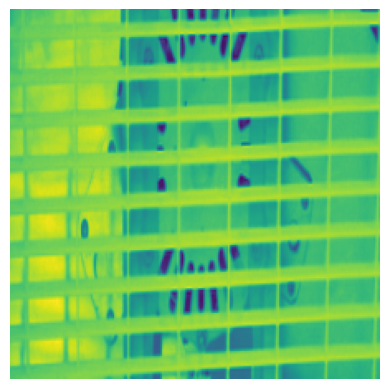

Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [4]:
# Now we can visualize a sample from the dataset
def show_image(img_tensor, title=''):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    
    plt.title(title)
    plt.show()

items = next(dl['train'])
print(len(items))
item = items[0]
stim = item['stim']
print(stim.shape)

resp = item['resp']
print(resp.shape)
neurons = resp.shape[1]
data_key = item['data_key']
print(data_key)
# plot the stim as grayscale image with matplotlib
show_image(stim[0]) 

extractor = ResnetExtractor()

## Training
Note that the results in this notebook are not of the longest / best training. The best results in the report required 80 epochs.

In [5]:
# Create the model
readin = ReadIn(neurons, (1024, 14, 14))
readin.to(device, dtype=READIN_DTYPE)
    

params = count_parameters(readin)
print("Total parametrs: ", params)


Total parametrs:  220345344


In [7]:
# Initialize optimizer, scheduler and criterion
optimizer = torch.optim.Adam(readin.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(dl['train'])*EPOCHS, eta_min=LEARNING_RATE/5)


training_avg_losses = []
validation_avg_losses = []
validation_epochs = []

# Perform training
for epoch in range(EPOCHS):
    dl = get_brainreader_mouse_dataloaders(config=config["data"]["brainreader_mouse"])['brainreader_mouse']
    for minibatch in tqdm(dl['train']):
        assert len(minibatch) == 1
        item = minibatch[0]
        stim = item['stim'].to(device)
        resp = item['resp'].to(device, dtype=READIN_DTYPE)

        stim_rgb = torch.cat([stim, stim, stim], dim=1)
        
        target = extractor.get_features(stim_rgb, verbose=False).to(device, dtype=READIN_DTYPE).unsqueeze(0)
        output = readin(resp)
        loss = criterion(output, target)
        loss.backward()

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        constant_loss = criterion(torch.zeros_like(output), target).item()
        relative_loss = loss.item() / (constant_loss + 1e-6)
        training_avg_losses.append(relative_loss)

        optimizer.zero_grad()
    print(f"Epoch {epoch} finished relative training loss {np.mean(training_avg_losses[-len(dl['train']):])}")

    if (EPOCHS - epoch) % EPOCHS_PER_VALIDATION == 0: # Calculate the validation loss
        readin.eval()

        val_losses = []

        with torch.no_grad():
            for minibatch in dl['val']:
                assert len(minibatch) == 1
                item = minibatch[0]
                stim = item['stim'].to(device)
                resp = item['resp'].to(device, dtype=READIN_DTYPE)
                stim_rgb = torch.cat([stim, stim, stim], dim=1)
                target = extractor.get_features(stim_rgb, verbose=False).to(device, dtype=READIN_DTYPE).unsqueeze(0)

                output = readin(resp)

                constant_loss = criterion(torch.zeros_like(output), target).item()
                relative_loss = loss.item() / (constant_loss + 1e-6)

                val_losses.append(relative_loss)

        print(f"Validation relative loss: {np.mean(val_losses)} with std. {np.std(val_losses)}")
        validation_avg_losses.append(np.mean(val_losses))
        validation_epochs.append(epoch)





  0%|                                                                                        | 0/71 [00:00<?, ?it/s]/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 64, 1024, 14, 14])) that is different to the input size (torch.Size([64, 1024, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████████████████████████████████████████████████████████████████████████▉ | 70/71 [00:20<00:00,  3.35it/s]/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 20, 1024, 14, 14])) that is different to the input size (torch.Size([20, 1024, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target

Epoch 0 finished relative training loss 0.30160790765697526


/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 52, 1024, 14, 14])) that is different to the input size (torch.Size([52, 1024, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation relative loss: 0.23438571327380858 with std. 0.002203992102702332


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 1 finished relative training loss 0.22254138656277075


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 2 finished relative training loss 0.2124628905635084


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.38it/s]


Epoch 3 finished relative training loss 0.20465774319445465


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.29it/s]


Epoch 4 finished relative training loss 0.19727764697589256


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.25it/s]


Epoch 5 finished relative training loss 0.1908239200837588
Validation relative loss: 0.1807818057537896 with std. 0.0016999400971515833


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 6 finished relative training loss 0.185723114693328


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.31it/s]


Epoch 7 finished relative training loss 0.1806615568958603


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.37it/s]


Epoch 8 finished relative training loss 0.17567809750596464


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 9 finished relative training loss 0.17044597530620767


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 10 finished relative training loss 0.16575322492604605
Validation relative loss: 0.17027123565182506 with std. 0.0016011063705729934


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 11 finished relative training loss 0.1611869594262533


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.32it/s]


Epoch 12 finished relative training loss 0.1563212080780959


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:22<00:00,  3.16it/s]


Epoch 13 finished relative training loss 0.15190103212857228


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.28it/s]


Epoch 14 finished relative training loss 0.14721670782602256


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.31it/s]


Epoch 15 finished relative training loss 0.14344937437975794
Validation relative loss: 0.15240326647848543 with std. 0.0014330890353894113


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 16 finished relative training loss 0.13959778995909514


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.30it/s]


Epoch 17 finished relative training loss 0.13594724876763672


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 18 finished relative training loss 0.13270172895311957


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 19 finished relative training loss 0.12957086090165482


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 20 finished relative training loss 0.12652995594743752
Validation relative loss: 0.1298055407592617 with std. 0.0012205965232454615


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.31it/s]


Epoch 21 finished relative training loss 0.12339587000035691


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 22 finished relative training loss 0.12064460731484541


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 23 finished relative training loss 0.11796957957748853


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 24 finished relative training loss 0.11522113104791518


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.31it/s]


Epoch 25 finished relative training loss 0.11269858407550337
Validation relative loss: 0.11561627112160963 with std. 0.001087170992364381


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 26 finished relative training loss 0.11049184041390515


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.32it/s]


Epoch 27 finished relative training loss 0.10840056611925764


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 28 finished relative training loss 0.10617495811655044


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 29 finished relative training loss 0.10425316275300522


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 30 finished relative training loss 0.10224607520930126
Validation relative loss: 0.09354407390748415 with std. 0.0008796201665493604


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.29it/s]


Epoch 31 finished relative training loss 0.10045739010329986


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 32 finished relative training loss 0.09888895446638699


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.37it/s]


Epoch 33 finished relative training loss 0.09714250920337052


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 34 finished relative training loss 0.09563494428611648


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.31it/s]


Epoch 35 finished relative training loss 0.09421844255745243
Validation relative loss: 0.09932488746356463 with std. 0.000933978716167585


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 36 finished relative training loss 0.09284326070067919


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 37 finished relative training loss 0.09159995485814947


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 38 finished relative training loss 0.09030986098083997


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.31it/s]


Epoch 39 finished relative training loss 0.08919517118800334


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 40 finished relative training loss 0.08820143228610806
Validation relative loss: 0.08933984586669835 with std. 0.0008400866759179292


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 41 finished relative training loss 0.0871300420184598


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 42 finished relative training loss 0.08632630005018427


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 43 finished relative training loss 0.08541134562236703


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 44 finished relative training loss 0.08464214708437408


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.37it/s]


Epoch 45 finished relative training loss 0.08398085108275734
Validation relative loss: 0.08040586128002851 with std. 0.0007560780083261366


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 46 finished relative training loss 0.08346866132682564


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 47 finished relative training loss 0.08298069184586211


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 48 finished relative training loss 0.08239269322976178


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 49 finished relative training loss 0.08208824870189996


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 50 finished relative training loss 0.08173295259365823
Validation relative loss: 0.08566114633101077 with std. 0.0008054948716154278


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 51 finished relative training loss 0.08140692571833125


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 52 finished relative training loss 0.08115774709171555


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 53 finished relative training loss 0.08093241471225643


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 54 finished relative training loss 0.08070228151859597


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 55 finished relative training loss 0.08045294659558322
Validation relative loss: 0.07988033277493028 with std. 0.0007511363219972093


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 56 finished relative training loss 0.0803113876980222


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 57 finished relative training loss 0.0800773525417016


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.38it/s]


Epoch 58 finished relative training loss 0.08000451234914362


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.38it/s]


Epoch 59 finished relative training loss 0.07993660069595383


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 60 finished relative training loss 0.07979230639624114
Validation relative loss: 0.08198244679532318 with std. 0.000770903067312924


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 61 finished relative training loss 0.07968959063182149


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 62 finished relative training loss 0.07960384983191575


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 63 finished relative training loss 0.07947299794636863


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 64 finished relative training loss 0.07932871791249328


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 65 finished relative training loss 0.07932704827824924
Validation relative loss: 0.08198244679532318 with std. 0.000770903067312924


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 66 finished relative training loss 0.07926378109494321


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 67 finished relative training loss 0.07917503544268234


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]


Epoch 68 finished relative training loss 0.07919956945694835


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 69 finished relative training loss 0.07907986716487114


Text(0.5, 0, 'Batch')

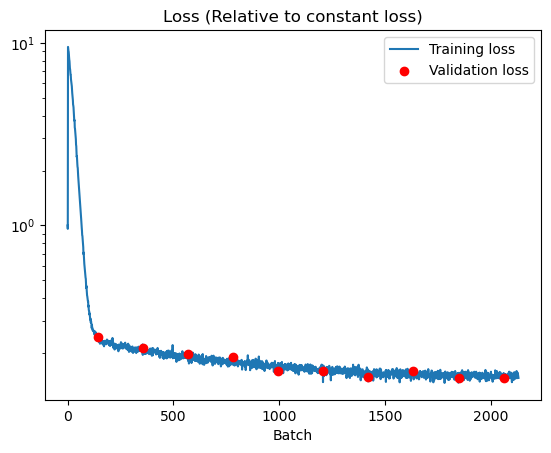

In [ ]:
validation_batches = [epoch * len(dl['train']) for epoch in validation_epochs]
plt.plot(training_avg_losses, label='Training loss')
plt.scatter(validation_batches, validation_avg_losses, label='Validation loss', color='red', zorder=2)
plt.yscale('log')
plt.legend()
plt.title('Loss (Relative to constant loss)')
plt.xlabel('Batch')

## Saving/loading the model

In [ ]:
readin_models_path = os.path.join(MODEL_PATH, "readin")
if not os.path.exists(readin_models_path):
    os.makedirs(readin_models_path)

# Switch based on whether you want to save the model
if True: # Save the model
# if False: # Load last model
    # Save the model
    model_path = os.path.join(readin_models_path, f"readin_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pt")
    print(f"Saving model to {model_path}")
    torch.save(readin,model_path)
else:

    model_path = os.path.join(readin_models_path, os.listdir(readin_models_path)[-1])
    readin = torch.load(model_path)
    print(f"Loaded model from {model_path}")

Saving model to /scratch/izar/vanousek/cs-433-project/models/readin/readin_2024-12-19_11-50-25.pt


## Visualize the model's perfomance

In [ ]:
# Collect the predictions
readin.eval()
val_losses = []
imgs = []
imgnet_activations_real = []
imgnet_activations_pred = []

dl = get_brainreader_mouse_dataloaders(config=config["data"]["brainreader_mouse"])['brainreader_mouse']
with torch.no_grad():
    for minibatch in dl['val']:
        assert len(minibatch) == 1
        item = minibatch[0]
        stim = item['stim'].to(device)
        resp = item['resp'].to(device, dtype=READIN_DTYPE)
        stim_rgb = torch.cat([stim, stim, stim], dim=1)
        target = extractor.get_features(stim_rgb, verbose=False).to(device, dtype=READIN_DTYPE).unsqueeze(0)

        output = readin(resp)

        constant_loss = criterion(torch.zeros_like(output), target).item()
        relative_loss = loss.item() / (constant_loss + 1e-6)

        val_losses.append(relative_loss)
        imgnet_activations_real.append(target)
        imgnet_activations_pred.append(output)
        imgs.append(stim)


print(f"Validation relative loss is {np.mean(val_losses)}")
print(f"With std: {np.std(val_losses)}")

Validation relative loss is 0.1460969244173067
With std: 0.0013737887994422584


<Figure size 640x480 with 0 Axes>

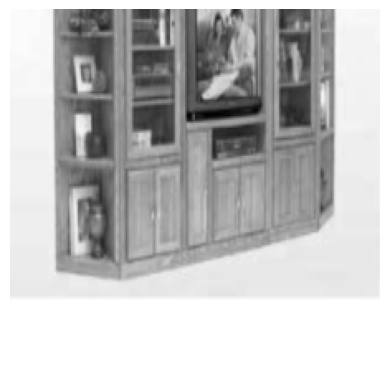

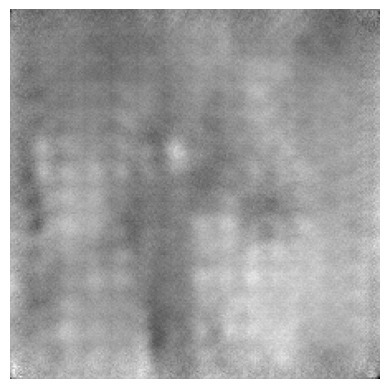

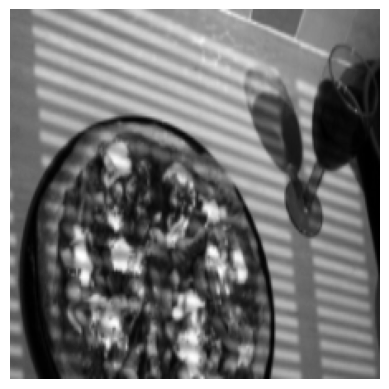

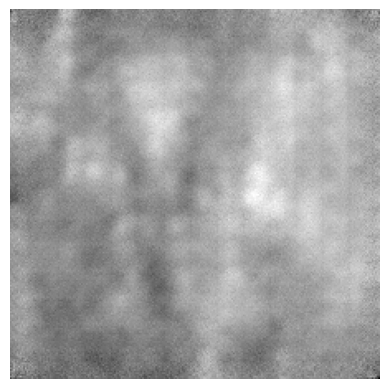

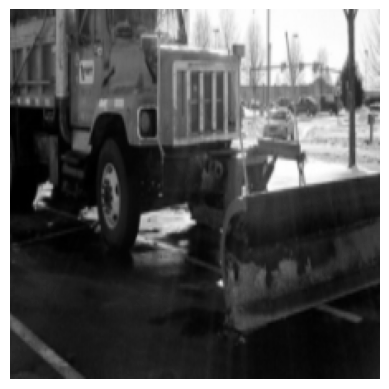

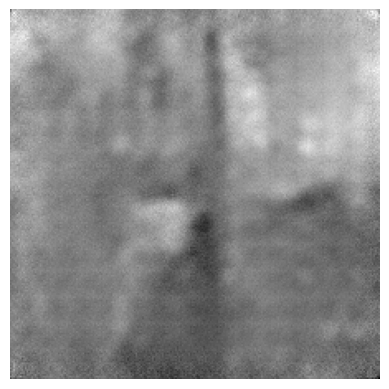

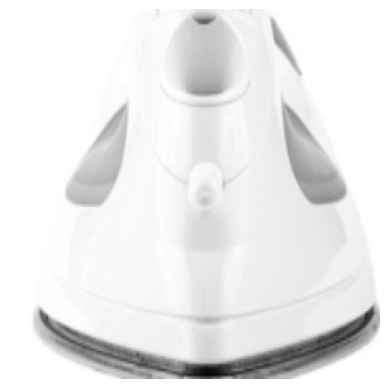

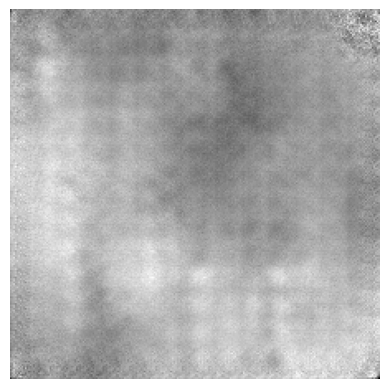

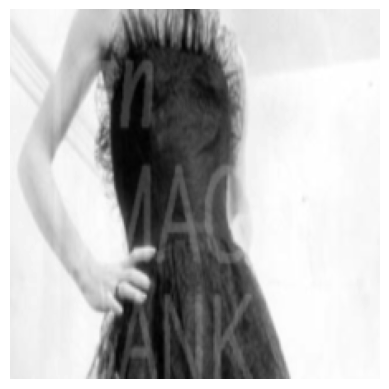

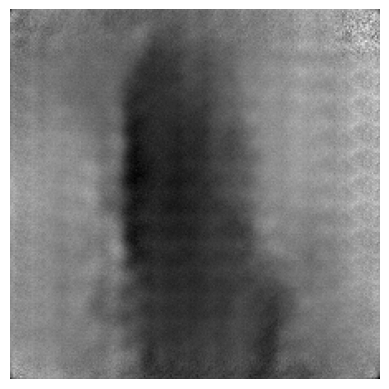

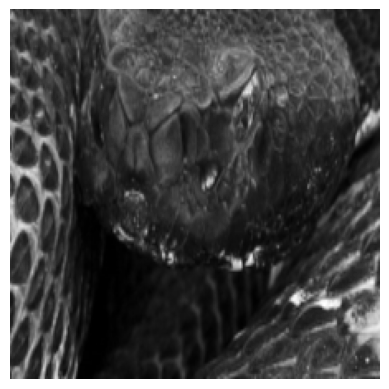

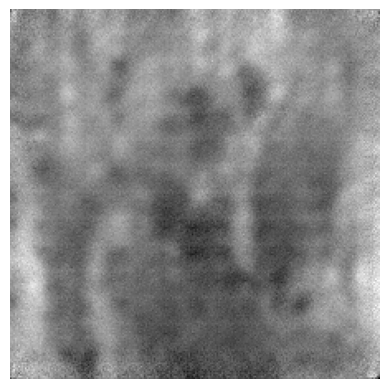

In [17]:
# We also visualize the result in combination with the upsample model (the second component)
output_model = torch.load(RESNET_DECODE_MODEL)
output_model.eval()
real, recon, pred = next(zip(imgs, imgnet_activations_real, imgnet_activations_pred))
plt.figure()
with torch.no_grad():
    pred_img = output_model(pred.to('cuda', dtype=torch.float32)).squeeze()
    for i in range(min(real.shape[0], 6)):
        plt.figure()
        plt.axis('off')
        plt.imshow(real[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
        plt.figure()
        plt.axis('off')
        plt.imshow(pred_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension

        plt.show()